# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## AT LAST - it's time for Fine Tuning!

After all this data preparation, and old school machine learning, we've finally arrived at the moment you've been waiting for. Fine-tuning a model.

In [ ]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI

/Users/arkar/dev/llm/llm_engineering/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [5]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [11]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [ ]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible,
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [10]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nGOLDEN ICEPURE Replacement for Kenmore 6, WF293, Refrigerator Water Filter 3 PACK\n💦𝐂𝐞𝐫𝐭𝐢𝐟𝐢𝐜𝐚𝐭𝐢𝐨𝐧 - The GOLDEN ICEPURE Refrigerator water filter is certified by the NSF/ANSI 42 and meets the requirements of NSF/ANSI/CAN 372. We guarantee the quality, health, and environmental friendliness of our products and services. 💦𝐏𝐞𝐫𝐟𝐨𝐫𝐦𝐚𝐧𝐜𝐞 - Using multi-stage filtration technology and high-grade coconut shell carbon'},
 {'role': 'assistant', 'content': 'Price is $22.59'}]

In [11]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [13]:
print(make_jsonl(train[:1]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nGOLDEN ICEPURE Replacement for Kenmore 6, WF293, Refrigerator Water Filter 3 PACK\n\ud83d\udca6\ud835\udc02\ud835\udc1e\ud835\udc2b\ud835\udc2d\ud835\udc22\ud835\udc1f\ud835\udc22\ud835\udc1c\ud835\udc1a\ud835\udc2d\ud835\udc22\ud835\udc28\ud835\udc27 - The GOLDEN ICEPURE Refrigerator water filter is certified by the NSF/ANSI 42 and meets the requirements of NSF/ANSI/CAN 372. We guarantee the quality, health, and environmental friendliness of our products and services. \ud83d\udca6\ud835\udc0f\ud835\udc1e\ud835\udc2b\ud835\udc1f\ud835\udc28\ud835\udc2b\ud835\udc26\ud835\udc1a\ud835\udc27\ud835\udc1c\ud835\udc1e - Using multi-stage filtration technology and high-grade coconut shell carbon"}, {"role": "assistant", "content": "Price is $22.59"}]}


In [14]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [15]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [16]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [17]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [18]:
train_file

FileObject(id='file-Eb6oS1PvLLLuDY3oyAzWK5', bytes=191656, created_at=1745627335, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

In [19]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [20]:
validation_file

FileObject(id='file-KQx6C14qkrnkPi5Xr3zV1k', bytes=47876, created_at=1745627335, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

# Step 2

I love Weights and Biases - a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

## And now time to Fine-tune!

In [21]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [22]:
train_file.id

'file-Eb6oS1PvLLLuDY3oyAzWK5'

In [25]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-lP99oq2mF3vPh7sj907znleq', created_at=1745628108, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-veXOa4g1YopZugZriLah1cgx', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-Eb6oS1PvLLLuDY3oyAzWK5', validation_file='file-KQx6C14qkrnkPi5Xr3zV1k', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-lP99oq2mF3vPh7sj907znleq'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [26]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-lP99oq2mF3vPh7sj907znleq', created_at=1745628108, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-veXOa4g1YopZugZriLah1cgx', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-Eb6oS1PvLLLuDY3oyAzWK5', validation_file='file-KQx6C14qkrnkPi5Xr3zV1k', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-lP99oq2mF3vPh7sj907znleq'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix

In [27]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [28]:
job_id

'ftjob-lP99oq2mF3vPh7sj907znleq'

In [29]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-lP99oq2mF3vPh7sj907znleq', created_at=1745628108, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-veXOa4g1YopZugZriLah1cgx', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-Eb6oS1PvLLLuDY3oyAzWK5', validation_file='file-KQx6C14qkrnkPi5Xr3zV1k', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-lP99oq2mF3vPh7sj907znleq'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [33]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-4SU7KIytKhFzShYhxoXv4D83', created_at=1745628208, level='info', message='Fine-tuning job started', object='fine_tuning.job.event', data=None, type='message'),
 FineTuningJobEvent(id='ftevent-sxAODtEf1ZS1aVXRthf9xEey', created_at=1745628206, level='info', message='Files validated, moving job to queued state', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-fXemGe0VVbqN21mLlUop8xxG', created_at=1745628108, level='info', message='Validating training file: file-Eb6oS1PvLLLuDY3oyAzWK5 and validation file: file-KQx6C14qkrnkPi5Xr3zV1k', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-FE2x5gYcjvLlZAMoJTGjjJPG', created_at=1745628108, level='info', message='Created fine-tuning job: ftjob-lP99oq2mF3vPh7sj907znleq', object='fine_tuning.job.event', data={}, type='message')]

# Step 3

Test our fine tuned model

In [7]:
fine_tuned_model_name = "ft:gpt-4o-mini-2024-07-18:personal:pricer:BQO2uzOe"

In [8]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:BQO2uzOe'

In [9]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [10]:
# Try this out

messages_for(test[0])

NameError: name 'test' is not defined

In [15]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [16]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [ ]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [18]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

57.99
21.66


In [19]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

General Electric Refrigerator Dispenser Solenoid Assembly
This part is a possible option when ice door won't open or shut properly or when water is not dispensing. This part fixes the following symptoms ice maker won't dispense ice, water dispenser will not dispense water, door sweats inside or outside, door won't open or close, leaking water, ice maker will not make ice, freezer section too warm, frost buildup. This part fixes the following symptoms ice maker won't dispense ice, water dispenser will not dispense water. This part is a possible option when ice door won't open or shut properly or when water is not dispensing. Genuine Replacement Part Manufacturer General Electric, Part Weight 8.8 ounces, Dimensions 5.9 x 1.1 x 

Price is $


1: Guess: $21.66 Truth: $57.99 Error: $36.33 SLE: 0.92 Item: General Electric WR62X10055 Refrigerator...
2: Guess: $24.99 Truth: $9.77 Error: $15.22 SLE: 0.78 Item: Beaquicy Upgraded W10766544 Gas Stove Kn...
3: Guess: $239.99 Truth: $353.20 Error: $113.21 SLE: 0.15 Item: Empava 30" Gas Stove Cooktop with 5 Ital...
4: Guess: $29.90 Truth: $36.95 Error: $7.05 SLE: 0.04 Item: Oil Painting Flower Magnetic Dishwasher ...
5: Guess: $22.22 Truth: $26.43 Error: $4.21 SLE: 0.03 Item: GE WH12X10531 Lid Switch Assembly
6: Guess: $22.22 Truth: $21.95 Error: $0.27 SLE: 0.00 Item: HQRP Bearing and Seal Kit Compatible wit...
7: Guess: $66.47 Truth: $67.00 Error: $0.53 SLE: 0.00 Item: Whirlpool 4392892 in-The-Wall Dryer Vent...
8: Guess: $66.00 Truth: $28.85 Error: $37.15 SLE: 0.65 Item: Edgewater Parts 5304516871, 131359602 Li...
9: Guess: $47.99 Truth: $16.99 Error: $31.00 SLE: 1.00 Item: Disposable Cups for Use in Keurig Brewer...
10: Guess: $274.00 Truth: $799.99 Error: $525.99 SLE: 1.14 Item: FR

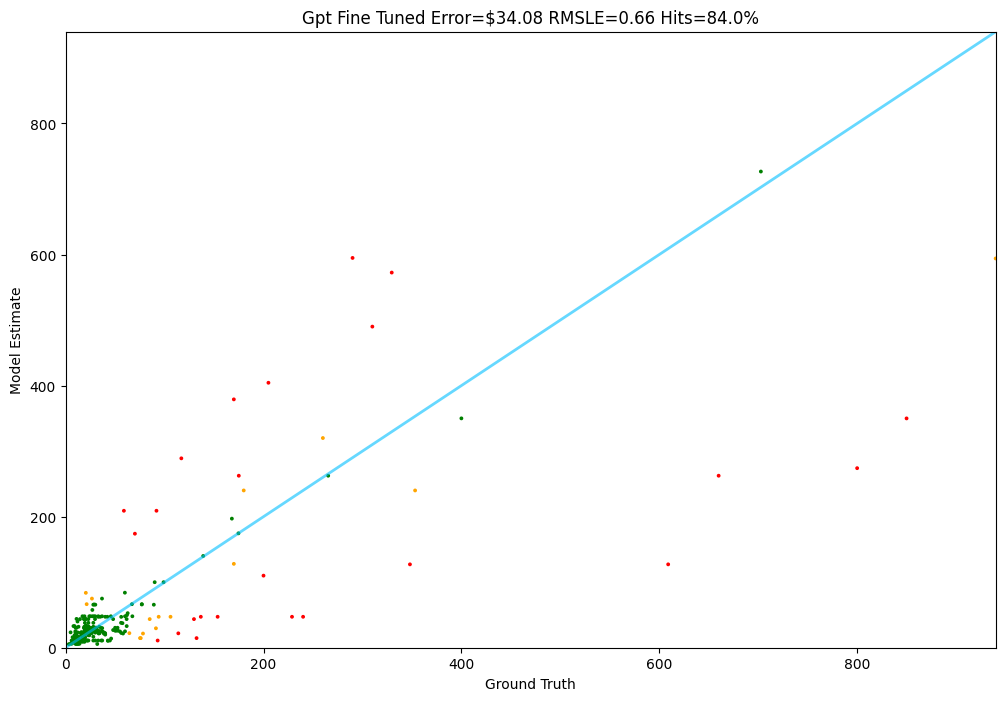

In [20]:
Tester.test(gpt_fine_tuned, test)